<a href="https://colab.research.google.com/github/jademuun/car_insurance_MTPL/blob/master/K%C3%B3pia_z%C3%A1pisn%C3%ADka_Bayesian_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 --version

Python 3.7.10


In [2]:
!pip install -q git+https://github.com/brendanhasz/probflow.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Libraries

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import countplot
from matplotlib.pyplot import figure, show
import timeit

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K

import probflow as pf
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from probflow.utils.metrics import as_numpy
import probflow.utils.ops as O
import tensorflow_probability as tfp
import math
tfd = tfp.distributions
kl = tfd.kullback_leibler

# Additional Preprocessing and functions

In [94]:
claim = pd.read_csv('/content/drive/MyDrive/data/scaled.csv')
claim = claim.drop(claim.columns[[0,1]], axis = 1)
train_idx = pd.read_csv('/content/drive/MyDrive/data/mylist.csv')

In [95]:
train = claim.iloc[train_idx.iloc[:,0],:]
test = claim.drop(train_idx.iloc[:,0], axis = 0)

In [96]:
# exposure is second column
train.head()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Area,Density,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,Region_Aquitaine,Region_Auvergne,Region_Basse-Normandie,Region_Bourgogne,Region_Bretagne,Region_Centre,Region_Champagne-Ardenne,Region_Corse,Region_Franche-Comte,Region_Haute-Normandie,Region_Ile-de-France,Region_Languedoc-Roussillon,Region_Limousin,Region_Midi-Pyrenees,Region_Nord-Pas-de-Calais,Region_Pays-de-la-Loire,Region_Picardie,Region_Poitou-Charentes,Region_Provence-Alpes-Cotes-D'Azur,Region_Rhone-Alpes
208669,0,0.38,-0.818182,-0.96,-0.195122,-0.666667,-0.5,1.0,1.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
174705,0,1.00,-0.454545,-0.98,-0.268293,-1.000000,0.5,-0.6,-0.146044,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
374480,0,0.13,-1.000000,-1.00,-0.317073,-1.000000,-0.5,0.6,0.791236,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
38228,0,1.00,-0.636364,-0.88,0.073171,-1.000000,-0.5,0.2,0.428966,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
317680,0,0.08,0.090909,-1.00,-0.487805,-1.000000,-0.5,0.6,0.631886,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [97]:
claim.head()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Area,Density,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,Region_Aquitaine,Region_Auvergne,Region_Basse-Normandie,Region_Bourgogne,Region_Bretagne,Region_Centre,Region_Champagne-Ardenne,Region_Corse,Region_Franche-Comte,Region_Haute-Normandie,Region_Ile-de-France,Region_Languedoc-Roussillon,Region_Limousin,Region_Midi-Pyrenees,Region_Nord-Pas-de-Calais,Region_Pays-de-la-Loire,Region_Picardie,Region_Poitou-Charentes,Region_Provence-Alpes-Cotes-D'Azur,Region_Rhone-Alpes
0,1,0.10,-0.818182,-1.00,-0.097561,-1.0,-0.5,0.2,0.392479,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0.77,-0.818182,-1.00,-0.097561,-1.0,-0.5,0.2,0.392479,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0.75,-0.636364,-0.96,-0.170732,-1.0,0.5,-0.6,-0.218122,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0.09,-0.454545,-1.00,-0.317073,-1.0,0.5,-0.6,-0.151136,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0.84,-0.454545,-1.00,-0.317073,-1.0,0.5,-0.6,-0.151136,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [98]:
# target
N_train = train.ClaimNb.to_numpy(dtype = 'float32')
N_test = test.ClaimNb.to_numpy(dtype = 'float32')

# exposure
v_train = train.Exposure.to_numpy(dtype = 'float32')
v_test = test.Exposure.to_numpy(dtype = 'float32')

train.loc[:,'Exposure'] = np.log(train.Exposure)
test.loc[:,'Exposure'] = np.log(test.Exposure)

# exposure is included in features
x_train = train.drop(['ClaimNb'], axis = 1).to_numpy(dtype = 'float32')
x_test = test.drop(['ClaimNb'], axis = 1).to_numpy(dtype = 'float32')



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [100]:
N_train

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [101]:
# plotting the loss
def plot_loss(history, yran,  measure = 'loss',
              valmeasure = 'val_loss', val = True):
  plt.plot(history.history[measure], label=measure)
  if val:
    plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim(yran)
  plt.xlabel('Epoch')
  plt.ylabel('Deviance')
  plt.legend()
  plt.grid(True)

# logarithm limit in deviance

# deviance according to Wuthrix
def deviance(lambd, N):
  log = 0
  NN = 0
  Mu = np.asarray(lambd)
  for n, mu  in zip(N, Mu):
    if n != 0:
      log += n * np.log(n / mu)
      NN += n
  result = 2 * (np.sum(Mu) - NN + log)/ N.shape[0]
  return result

def prediction(model):
  training = model.predict(x_train).flatten()
  testing = model.predict(x_test).flatten()
  print('Deviancia na trenovacej mnozine je: ', deviance(training, N_train))
  print('Deviancia na testovacej mnozine je: ', deviance(testing, N_test))
  print('Priemerna frekvencia na testovacej mnozine: ', testing.sum() / v_test.sum())


@as_numpy
def poisson_deviance(y_true, y_pred):
  y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
  y_true = math_ops.cast(y_true, y_pred.dtype)
  return 2 * K.mean(y_pred - y_true + y_true * math_ops.log((y_true + K.epsilon()) /(y_pred + K.epsilon())), axis=-1)
 

In [8]:
x_train.shape

(610212, 38)

# Bayesian model

In [84]:
log_lambda_hat = np.log(0.10022).astype('float32')
log_lambda_hat

-2.3003876

In [12]:
class Mixture_normal(pf.BaseDistribution):

    def __init__(self, mean, std, pi):
        self.mean = mean
        self.std = std
        self.pi = pi

    def __call__(self):
        return pi * tfd.Normal(self.mean, self.std)

In [120]:
pi = [1/2, 1/4, 3/4]
sigma1 = [1, np.exp(-1)]
sigma2 = [np.exp(-5), np.exp(-7)]
def priors(sigma1, sigma2, prob):
  dist = pf.Mixture(distributions= pf.Normal(loc = [0, sigma1], scale = [0, sigma2]), probs = prob)
  return dist

prior1 = priors(sigma1[0], sigma2[0], pi[0])
prior1.sample(5)

In [142]:
pf.Mixture(distributions = pf.Normal(loc = [0,1], scale = [0.2, 5]), probs = [0.2,0.8])

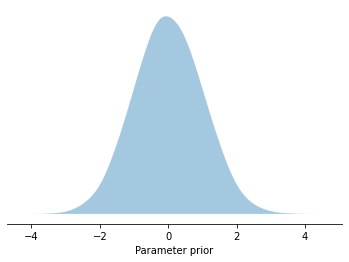

In [145]:
pa = pf.Parameter(posterior=pf.Mixture)
pa.prior_plot()

In [146]:
pa.posterior_plot()

TypeError: ignored

In [232]:
# Needed if this cell is run more than once.
if (tfd.Normal, tfd.MixtureSameFamily) in kl._DIVERGENCES:
  del kl._DIVERGENCES[(tfd.Normal, tfd.MixtureSameFamily)]

NUM_MC_SAMPLES = 10

@kl.RegisterKL(tfd.Normal, tfd.MixtureSameFamily)
def _mc_kl_msf_msf(a, b, seed=None, name='_mc_kl_msf_msf'):
  with tf.name_scope(name):
    s = a.sample(NUM_MC_SAMPLES, seed)
    return tf.reduce_mean(
        a.log_prob(s) - b.log_prob(s), axis=0, name='KL_MSF_MSF')

In [165]:
lol  =  pf.Mixture(distributions = pf.Normal(loc = [0,1], scale = [0.2, 5]), probs = [0.2,0.8])

In [249]:
haha = tfd.Normal(0,1)

In [250]:
kek = pf.Normal(0,1)

In [301]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.7, 0.3]),
    components_distribution=tfd.Normal(
      loc=[0, 0],       # One for each component.
      scale=[1, math.exp(-3.5)]))  # And same here.

In [256]:
pf.utils.ops.kl_divergence(haha , gm)

<tf.Tensor: shape=(), dtype=float32, numpy=0.10488673>

In [241]:
tfd.kl_divergence(haha, gm)

<tf.Tensor: shape=(), dtype=float32, numpy=4.1657414>

In [225]:
gm.kl_divergence(kek)

NotImplementedError: ignored

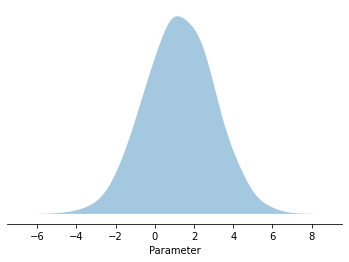

In [260]:
cau = pf.Parameter(prior = tfd.Normal(0,3), posterior = tfd.Normal)
cau.posterior_plot()

In [308]:
# first hidden layer
class FirstLayer(pf.Dense):

    def __init__(self, d_in: int, d_out: int, aprior):
        self.w = pf.Parameter([d_in - 1, d_out], posterior= tfd.Normal, prior = aprior)
        self.b = pf.Parameter([1, d_out],posterior = tfd.Normal, prior = aprior)

    def __call__(self, x):
        x = x[:,1::]
        return x @ self.w() + self.b()

# input offset layer
class Exposition(pf.Dense):

    def __init__(self, d_in: int, d_out: int):
        self.r = 5 # must be some parameter even if not used
    
    def __call__(self, x):
        y = tf.convert_to_tensor(x[:,0])
        y = tf.reshape(y, [-1,1])
        return y

# other hidden layers
class HiddenLayer(pf.Dense):

    def __init__(self, d_in: int, d_out: int, aprior):
        self.w = pf.Parameter([d_in, d_out],posterior = tfd.Normal, prior = aprior)
        self.b = pf.Parameter([1, d_out], posterior = tfd.Normal, prior = aprior)

    def __call__(self, x):
        return x @ self.w() + self.b()


class LastLayer(pf.Dense):

    def __init__(self, d_in: int, d_out: int):
        self.w = pf.Parameter([d_in, d_out], posterior = tfd.Normal, prior = tfd.Normal(0,0.5))
        self.b = pf.Parameter([1, d_out], posterior = tfd.Normal, prior = tfd.Normal(-2.3, 0.3))

    def __call__(self, x):
        return x @ self.w() + self.b()


# creating network architecture
class DNetwork(pf.DenseNetwork):

    def __init__(self, dims, aprior):
        d = len(dims) # number of layers
        self.offset = Exposition(1, 1)
        self.layers = [FirstLayer(dims[0], dims[1], aprior)]
        self.layers += [HiddenLayer(dims[i], dims[i + 1], aprior) for i in range(1, d - 2)]
        self.layers += [LastLayer(dims[d-2], dims[d-1])]
        self.activations = (d - 2) * [tf.nn.relu]
        self.activations += [lambda x: x] # last activation must be positive
        # because it enters as the mean to the poisson dristribution
        

    def __call__(self, x):
        ofset = self.offset(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = self.activations[i](x)
        x = tf.add(x, ofset)
        x = O.exp(x)
        return x


# defining the model with Poisson distribution as distribution of targets
class PoisRegression(pf.ContinuousModel):

    def __init__(self, dims, aprior):
        self.net = DNetwork(dims, aprior)

    def __call__(self, x):
        return pf.Poisson(self.net(x))

In [309]:
bayes_first = PoisRegression([38,100,70,50,20,1], gm)


In [310]:
bayes_first(x_test)

In [312]:
# Record the ELBO
monitor_elbo = pf.MonitorELBO()

# Record Poisson deviance
pois_dev = pf.MonitorMetric(poisson_deviance, x_test, N_test)
# Anneal the learning rate from ~2e-4 to ~0
lr_scheduler = pf.LearningRateScheduler(lambda e: 2e-4-2e-6*e)
# List of callbacks
callbacks = [monitor_elbo]

In [313]:
%%time
bayes_first.fit(x_train, N_train, epochs = 30, batch_size=1000, callbacks=callbacks, num_workers=4, flipout = False, lr = 0.005, eager = True)

CPU times: user 48min 33s, sys: 27min 41s, total: 1h 16min 15s
Wall time: 1h 8min 43s


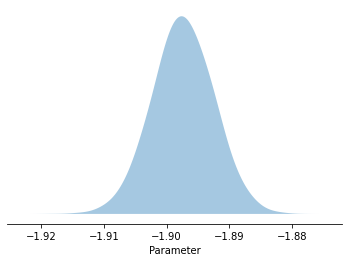

In [294]:
bayes_first.parameters[7].posterior_plot()

In [267]:
bayes_second.kl_loss()

NameError: ignored

In [22]:
bayes_first.parameters

[<pf.Parameter Parameter shape=[37, 40]>,
 <pf.Parameter Parameter shape=[1, 40]>,
 <pf.Parameter Dense_weights shape=[40, 30]>,
 <pf.Parameter Dense_bias shape=[1, 30]>,
 <pf.Parameter Dense_weights shape=[30, 20]>,
 <pf.Parameter Dense_bias shape=[1, 20]>,
 <pf.Parameter Dense_weights shape=[20, 1]>,
 <pf.Parameter Dense_bias shape=[1, 1]>]

In [315]:
prediction(bayes_first)

Deviancia na trenovacej mnozine je:  0.32591602013783816
Deviancia na testovacej mnozine je:  0.33493961440931563
Priemerna frekvencia na testovacej mnozine:  0.09606061


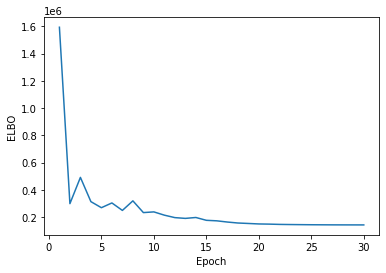

In [314]:
monitor_elbo.plot()
# pozret v plt.plot ako priblizit, priblizit to blizsie ako sa to meni

In [99]:
bayes_first.predict(x_test)

array([[0.12252478],
       [0.00824521],
       [0.07389804],
       ...,
       [0.00300581],
       [0.00141824],
       [0.00078752]], dtype=float32)

In [131]:
bayes_first.kl_loss()

<tf.Tensor: shape=(), dtype=float32, numpy=941880.0>

In [316]:
first = bayes_first.predict(x_test)

In [ ]:
bayes_first.predictive_sample(x_test[5666], n = 1000).mean()

0.052

In [26]:
bayes_first.parameters

[<pf.Parameter Parameter shape=[37, 40]>,
 <pf.Parameter Parameter shape=[1, 40]>,
 <pf.Parameter Dense_weights shape=[40, 30]>,
 <pf.Parameter Dense_bias shape=[1, 30]>,
 <pf.Parameter Dense_weights shape=[30, 20]>,
 <pf.Parameter Dense_bias shape=[1, 20]>,
 <pf.Parameter Dense_weights shape=[20, 1]>,
 <pf.Parameter Dense_bias shape=[1, 1]>]

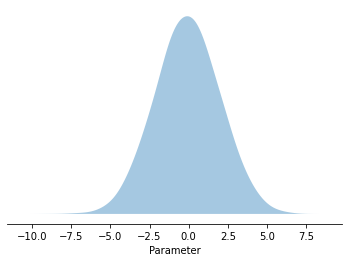

In [272]:
bayes_first.parameters[7].posterior_plot()

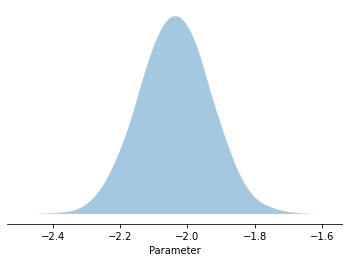

In [319]:
bayes_first.parameters[9].posterior_plot()

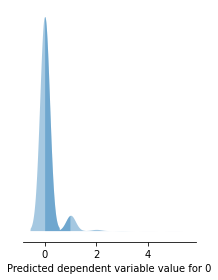

In [ ]:

bayes_first.pred_dist_plot(x_test[6888], ci=0.95,
                     individually=True, cols=2)



In [320]:

results = pd.DataFrame()
results['first'] = first.flatten()
#results['second'] = second.flatten()
#results['third'] = third.flatten()

In [ ]:
len(first)

67801

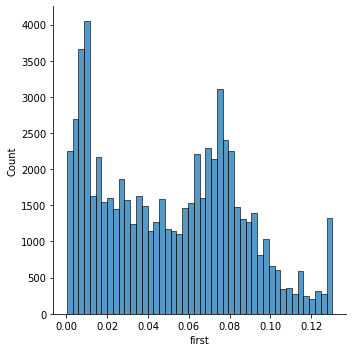

In [321]:
sns.displot(results, x = 'first')

In [ ]:
bayes_second.predictive_sample(x_test).shape

(1000, 67801, 1)

In [ ]:
#bayes_first.posterior_plot(params= bayes_first.parameters[1], cols = 4)
bayes_first.prob(x_test_full,N_test)

TypeError: ignored

In [ ]:
N_test

12        1
22        1
35        1
48        1
57        1
         ..
677928    0
677930    0
677950    0
677981    0
677999    0
Name: ClaimNb, Length: 67801, dtype: int64

In [ ]:
prediction(bayes_first)

Deviancia na trenovacej mnozine je:  0.3206213978682769
Deviancia na testovacej mnozine je:  0.3304042294180813


In [105]:
bayes_first.save('/content/drive/MyDrive/models_diplom/bayes_model_1.pfm')

RuntimeError: ignored